# Template for Practical work on the Conversion of sampling frequency and STFT


*From R. Badeau and G. Richard (with help from P. Vernhet), MAJ:2020*

**python version : 3.6**

In [157]:
import os, sys, wave, struct

import numpy as np
import pyaudio
import pandas as pd
import matplotlib.pyplot as plt
import scipy
from IPython.display import Audio
import time

from copy import deepcopy
from math import ceil
from scipy.io.wavfile import write

## Functions

In [158]:
def load_sound(file):
    return wave.open(file, 'rb')


def play_sound(file, chunk = 1024):
    """
    Script from PyAudio doc
    """
    wf = load_sound(file)
    p = pyaudio.PyAudio()
    stream = p.open(format=p.get_format_from_width(wf.getsampwidth()),
                    channels=wf.getnchannels(),
                    rate=wf.getframerate(),
                    output=True)
    data = wf.readframes(chunk)

    while data:
        stream.write(data)
        data = wf.readframes(chunk )

    stream.stop_stream()
    stream.close()
    p.terminate()
    
    
def plot_sound(data, times, name='default_name', save=False):
    plt.figure(figsize=(30, 4))
    plt.fill_between(times, data)
    plt.xlim(times[0], times[-1])
    plt.xlabel('time (s)')
    plt.ylabel('amplitude')
    if save:
        plt.savefig(name+'.png', dpi=100)
    plt.show()

## Reading and playing .wav file

Choose the name of sound for the rest of the notebook. Sounds are assumed to be set in a folder named 'sons_mutltipitch' (same directory as notebook).

In [159]:
data_path = os.getcwd()
filename = 'caravan_48khz.wav'
sound = os.path.join(data_path, filename) 

### **Using wave**

In [160]:
wavefile = load_sound(sound)
print(wavefile.getparams())

_wave_params(nchannels=1, sampwidth=2, framerate=48000, nframes=805733, comptype='NONE', compname='not compressed')


In [161]:
play = False
if play :
    play_sound(sound) 

In [162]:
Fs = int(wavefile.getframerate())
num_samples = int(wavefile.getnframes())
data = wavefile.readframes(num_samples)
data = struct.unpack('{n}h'.format(n=num_samples), data)
x = np.array(data)

In [163]:
timestep = 1/float(Fs)
times = np.arange(len(x))*timestep

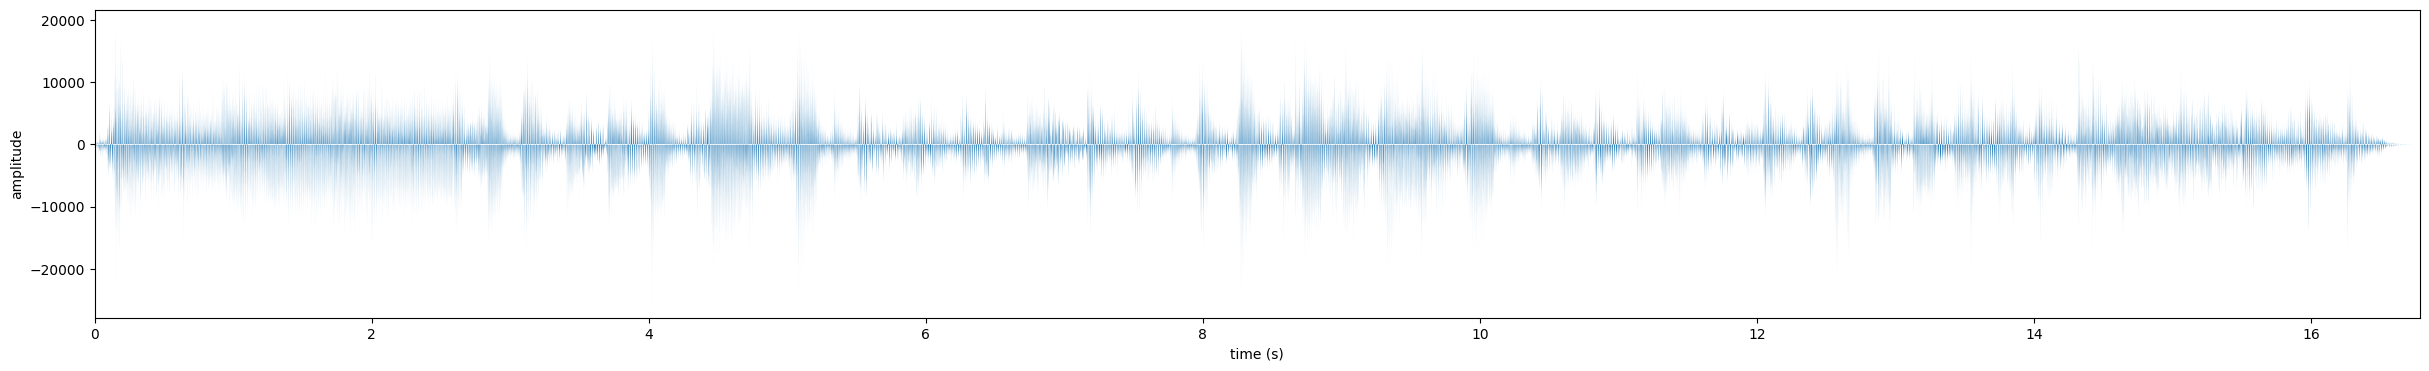

In [164]:
plot_sound(x, times)

In [165]:
write('new_caravan.wav', Fs, np.array(x, dtype=np.int16)) # to write a new wave file

## Partie I :

Q1:

 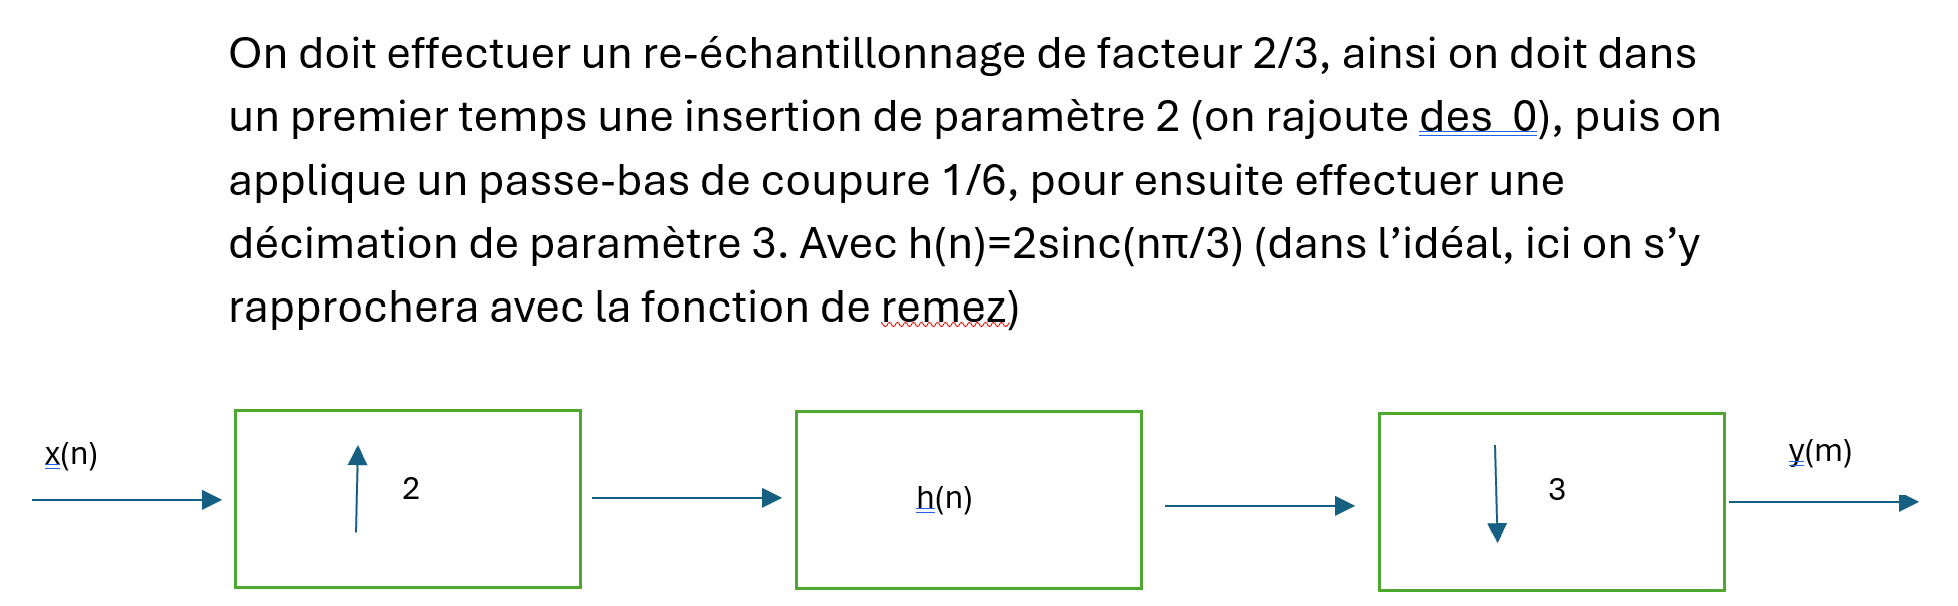

Q2:

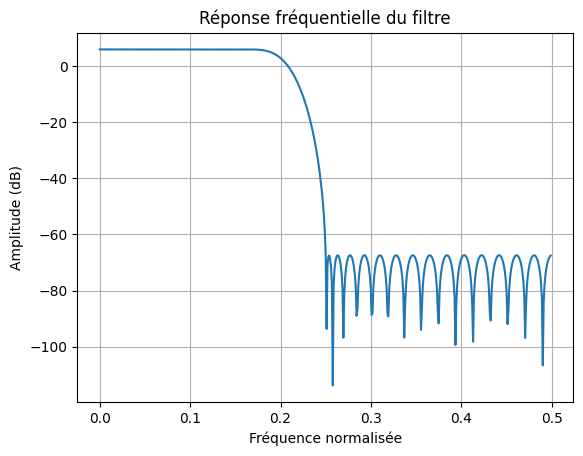

In [199]:
from scipy.signal import remez, freqz, lfilter


Fs_in = 48e3
Fs_out = 32e3 
nu_c = 1/6
nu_a = 1/4

# Fonction de Remez
numtaps = 51
h = 2*remez(numtaps, [0, nu_c, nu_a, .5], [1, 0])

# Réponse fréquentielle du filtre
w, h_freq = freqz(h)
plt.plot(0.5  * w / np.pi, 20 * np.log10(np.abs(h_freq)))
plt.title("Réponse fréquentielle du filtre")
plt.xlabel("Fréquence normalisée")
plt.ylabel("Amplitude (dB)")
plt.grid()
plt.show()

On observe bien un difference de plus de 50 dB entre les fréquences (normalisées) de 1/6 et 1/4

Q3:

0.19918036460876465


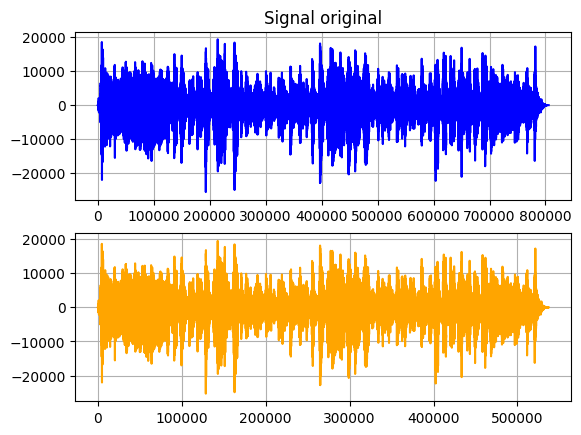

In [200]:

def upsampled2(x):
    xbis=[]
    for a in x:
        xbis.append(a)
        xbis.append(0)
    return xbis

# Fonction de conversion du taux d'échantillonnage
def resample_signal(x):
    x_upsampled = upsampled2(x)
    x_filtered = lfilter(h, [1.0], x_upsampled)
    y = x_filtered[::3]
    return y

t0=time.time()

y=resample_signal(x)

print(time.time()-t0)

# Signal original
plt.subplot(2, 1, 1)
plt.plot(x, label='Signal original', color='blue')
plt.title('Signal original')
plt.grid(True)

#  Signal réechantilloné
plt.subplot(2, 1, 2)
plt.plot(y, label='Signal à 36khz', color='orange')
plt.grid(True)


In [168]:

write('caravan_32khz.wav', int(Fs_out), np.array(y, dtype=np.int16)) # to write a new wave file
sound1 = os.path.join(data_path, 'caravan_32khz.wav') 
play = False
if play :
    play_sound(sound1) 

Q4:

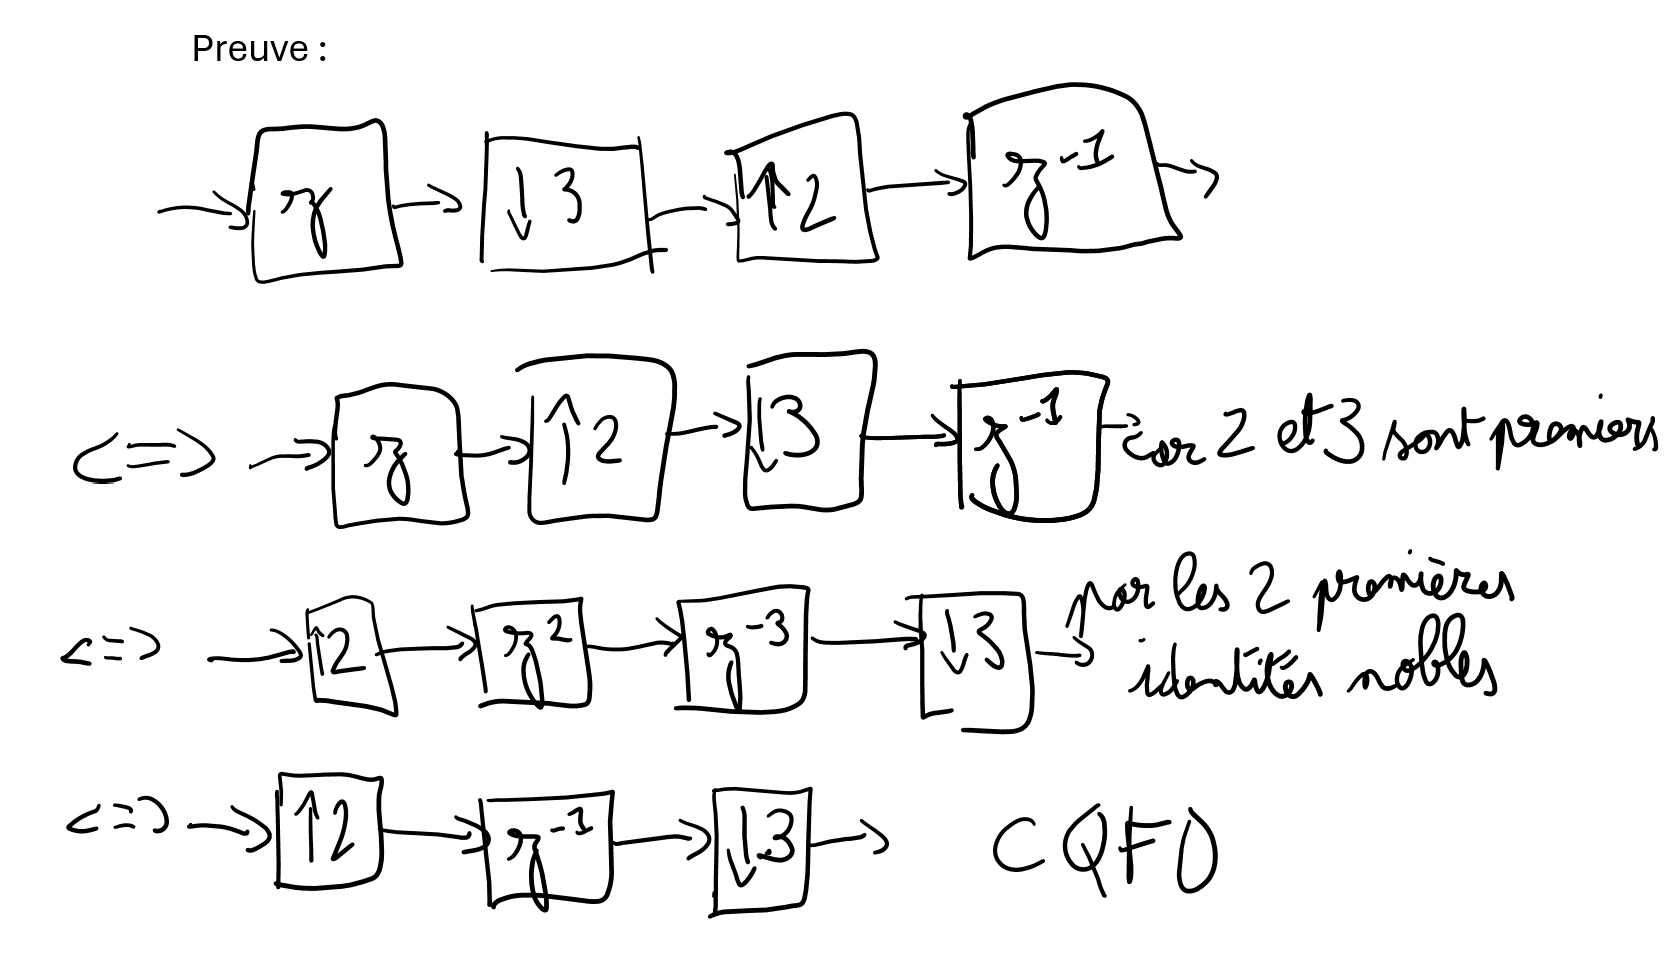

Cela permet les équivalences suivantes :

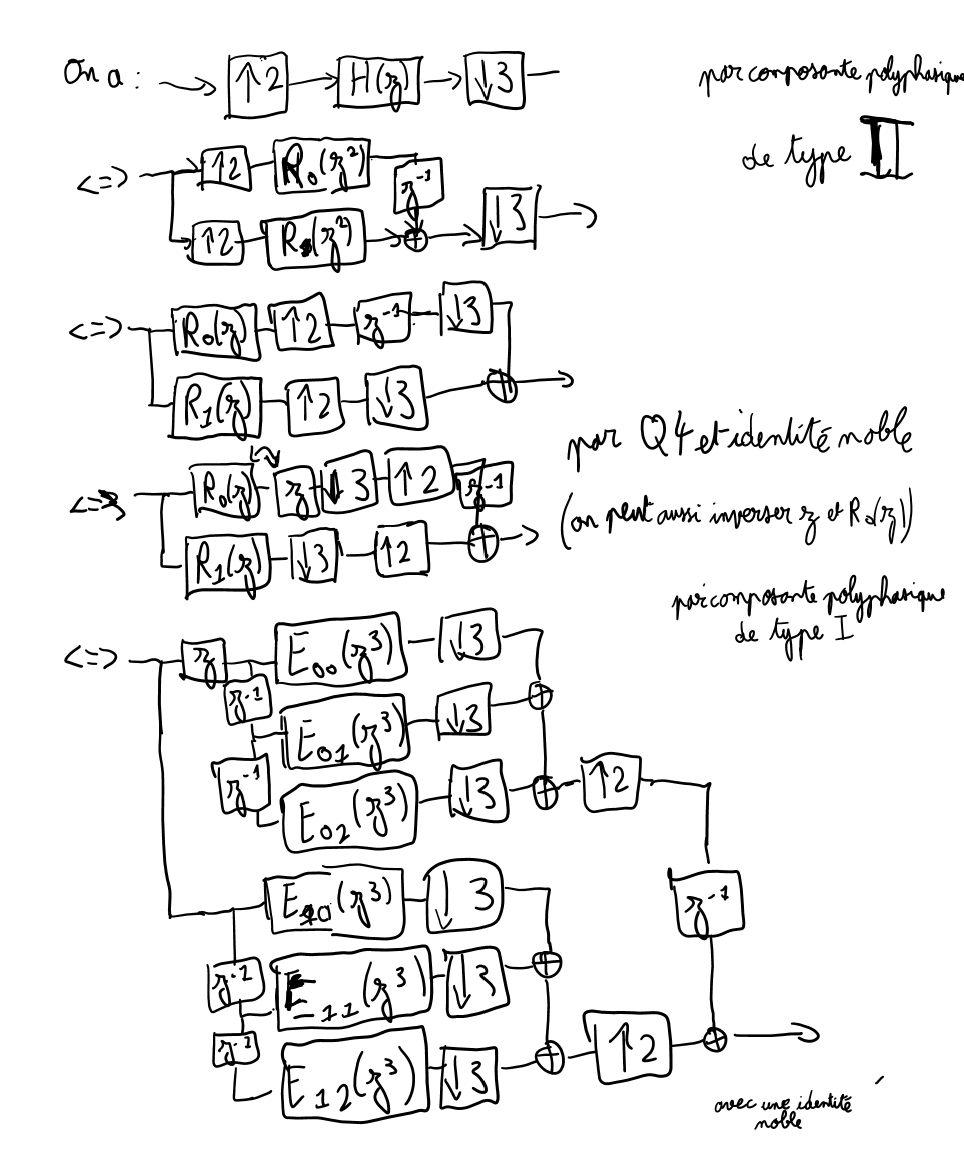
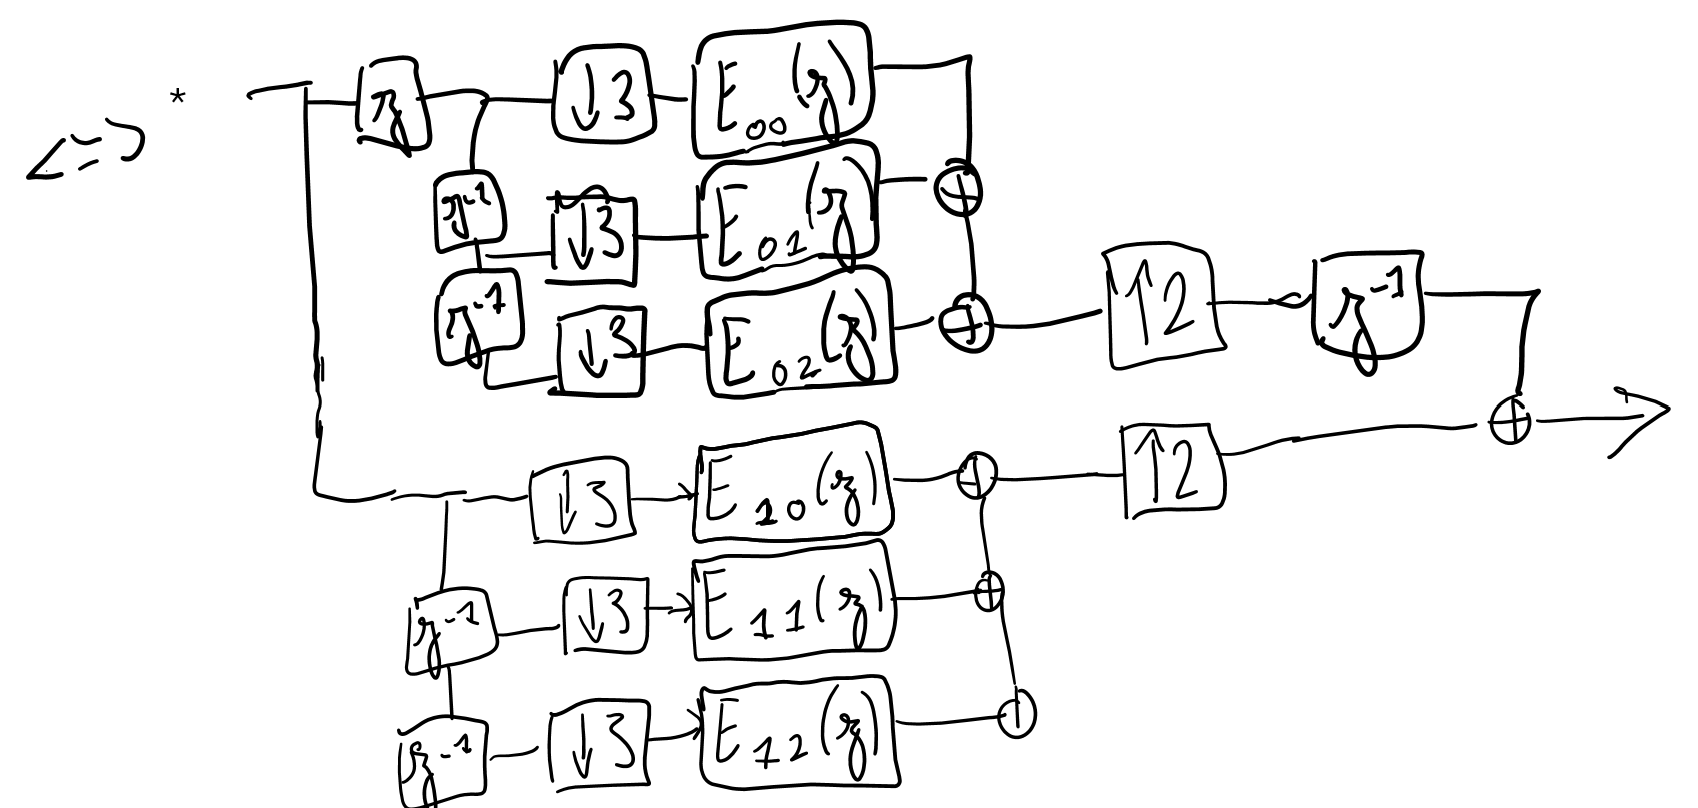

Q5:

On utilise la méthode explicité ci-dessus

0.034980058670043945


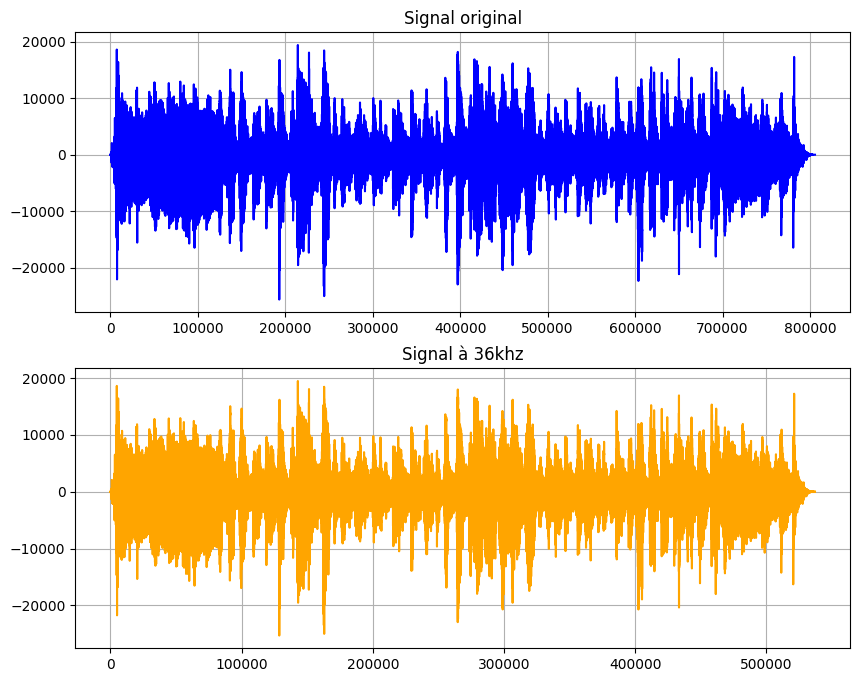

In [201]:

L=2
M=3

def resample_signal2(x):
    #filtres polyphase
    R0=h[::2]
    R1=h[1::2]

    E00=R0[::3]
    E01=R0[1::3]
    E02=R0[2::3]
    E10=R1[::3]
    E11=R1[1::3]
    E12=R1[2::3]
    #shift
    x_1 = np.roll(x, 1)
    x_2 = np.roll(x_1, 1)
    x_3 = np.roll(x_2, 1)
    E = [h[i::M] for i in range(M)]
    #décimation
    w_0 = x[::M]
    w_1 = x_1[::M]
    w_2 = x_2[::M]
    w_3 = x_3[::M]
    #filtrage
    filtered_0 = lfilter(E00, 1, w_0) + lfilter(E01, 1, w_1) + lfilter(E02, 1, w_2)
    filtered_1 = lfilter(E10, 1, w_1) + lfilter(E11, 1, w_2) + lfilter(E12, 1, w_3)
    #réunion des signaux
    y = np.zeros(int(L*num_samples/M)+1)
    y[::L] = filtered_0
    y[1::L] = filtered_1
    return y

t0 = time.time()
y1=resample_signal2(x)
print(time.time() - t0)

plt.figure(figsize=(10, 8))

# Signal original
plt.subplot(2, 1, 1)
plt.plot(x, label='Signal original', color='blue')
plt.title('Signal original')
plt.grid(True)

#  Signal réechantilloné
plt.subplot(2, 1, 2)
plt.plot(y1, label='Signal à 36khz', color='orange')
plt.title('Signal à 36khz')
plt.grid(True)


In [170]:
write('caravan_32khz2.wav', int(Fs_out), np.array(y1, dtype=np.int16)) # to write a new wave file
sound11 = os.path.join(data_path, 'caravan_32khz2.wav') 
play = False
if play :
    play_sound(sound11) 

Q6:

Dans les 2 cas on a le même résultat, cependant on observe que la 2ème implémentation est bien plus rapide : 0.04201531410217285 s pour la deuxième contre 0.24984192848205566 s pour la 1ère. Soit environ 6x plus rapide.

## Signal analysis with the STFT

In [171]:
N = x.shape[0] # % longueur du signal
Nw = 32
w = np.hanning(Nw) # définition de la fenetre d'analyse
ws = w.copy; # définition de la fenêtre de synthèse
R = 1 # incrément sur les temps d'analyse, appelé hop size, t_a=uR
M = 32  #ordre la tfd
L = M/2+1
affich = 1; # pour affichage du spectrogramme, 0 pour
             # pour faire analyse/modif/synthèse sans affichage
             # note: cf. spectrogram sous Matlab
Nt = np.rint((N - Nw) / R) # calcul du nombre de tfd à calculer
Nt = Nt.astype(int)
y = np.zeros((N,1)) # signal de synthèse

if affich:
    Xtilde = np.zeros((M,Nt),dtype=complex)

In [172]:
for u in np.arange(0,Nt).reshape(-1): # boucle sur les trames
    deb = u * R + 1 # début de trame
    fin = deb + Nw # fin de trame
    tx = np.multiply(x[np.arange(deb.astype(int),fin.astype(int))],w) # calcul de la trame 
    X = np.fft.fft(tx,M) # tfd à l'instant b
    if affich:
        Xtilde[:,u] = X
    # opérations de transformation (sur la partie \nu > 0)
    # ....
    Y = X.copy
    # fin des opérations de transformation
    # resynthèse
    # overlap add

def extents(f):
  delta = f[1] - f[0]
  return [f[0] - delta/2, f[-1] + delta/2]

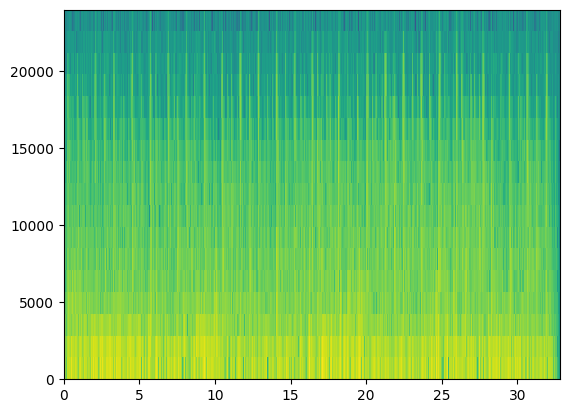

In [173]:
if affich:
    plt.imshow(20*np.log10(np.abs(Xtilde[np.arange(0,int(L)),:])), aspect='auto',interpolation='none',
               origin='lower', extent=[0, Nt * R / Fs + Nw / 2, 0, Fs/2])
    

## Partie II :

Q1:

C:\Users\alexa\AppData\Local\Temp\ipykernel_10776\1978470070.py:7: RuntimeWarning: divide by zero encountered in log10
  W = 20 * np.log10(abs(np.fft.fftshift(np.fft.fft(w, M))))


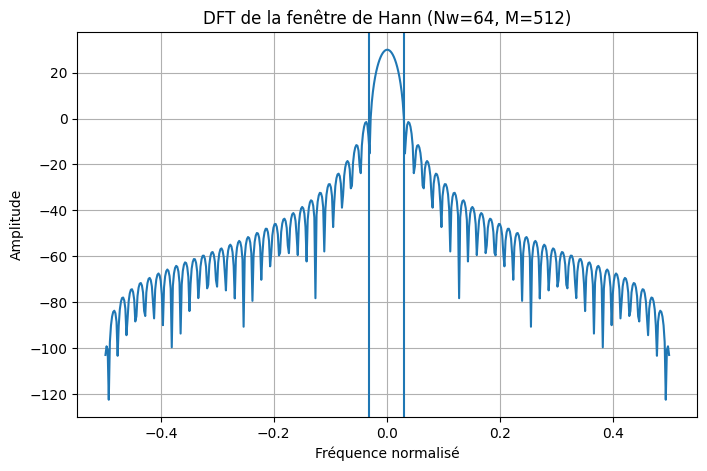

La largeur du lobe principale est de 0.0625


In [174]:

Nw=64
M=512
#création fenêtre de Haan
w = np.hanning(Nw) 

# calcul de la  DFT
W = 20 * np.log10(abs(np.fft.fftshift(np.fft.fft(w, M))))

# fréquences normalisées
freqs = np.linspace(-0.5, 0.5, len(W))


plt.figure(figsize=(8, 5))
plt.plot(freqs, W)
plt.title(f'DFT de la fenêtre de Hann (Nw={Nw}, M={M})')
plt.xlabel('Fréquence normalisé')
plt.ylabel('Amplitude')
plt.axvline(-2/Nw, linestyle = '-')
plt.axvline(2/Nw, linestyle = '-')
plt.grid()
plt.show()


main_lobe_width = 2 * 2 / Nw
print("La largeur du lobe principale est de " + str(main_lobe_width))


Q2


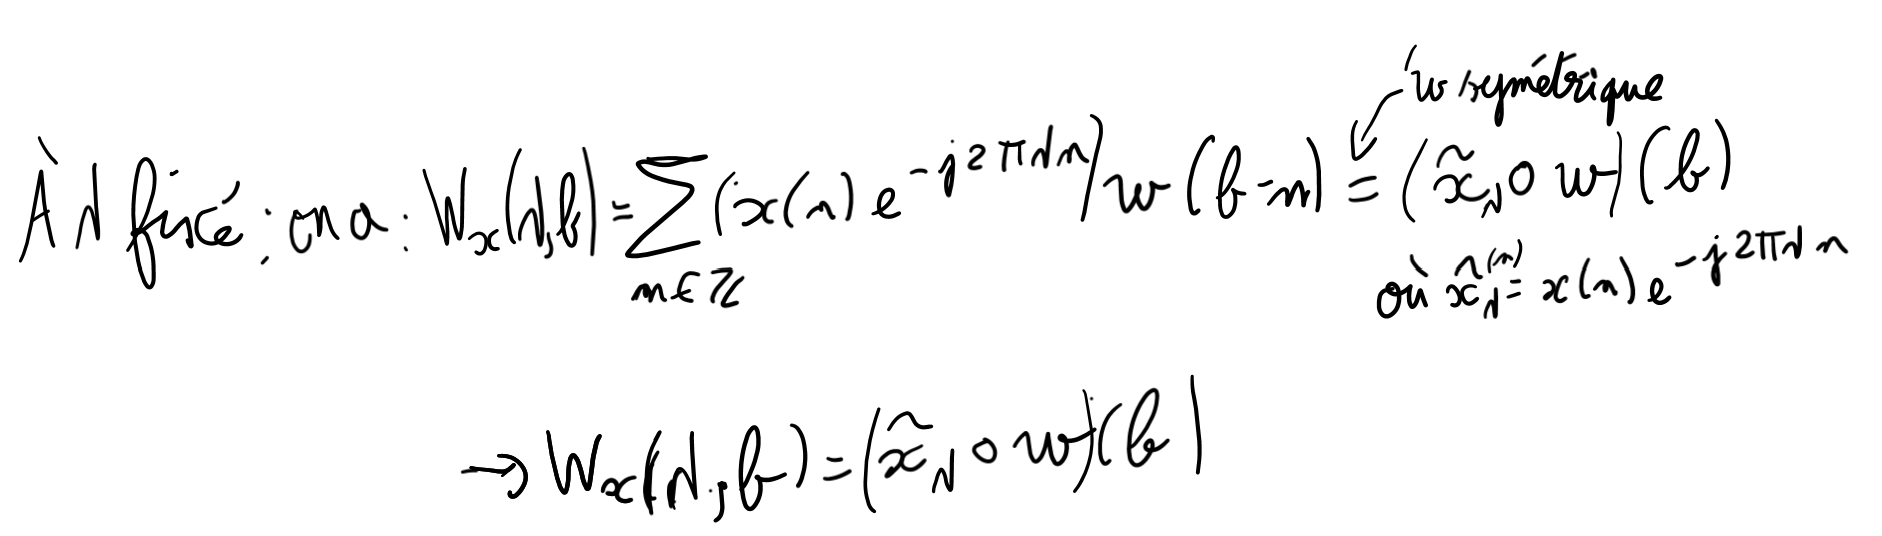

Ici la convolution peut être vu comme l'application d'un filtre, ici la fenêtre de Hann atténue les hautes fréquences(cf graphe porte de Han). Ainsi la transformation peut être assimilé à un filtre passe bas.

- Type 1 : lorsque la fenêtre de Hann a une longueur impair (p=Nw-1 -> pair)
- Type 2 : lorsque la fenêtre de Hann a une longueur pair (p=Nw-1 -> impair)

Q3

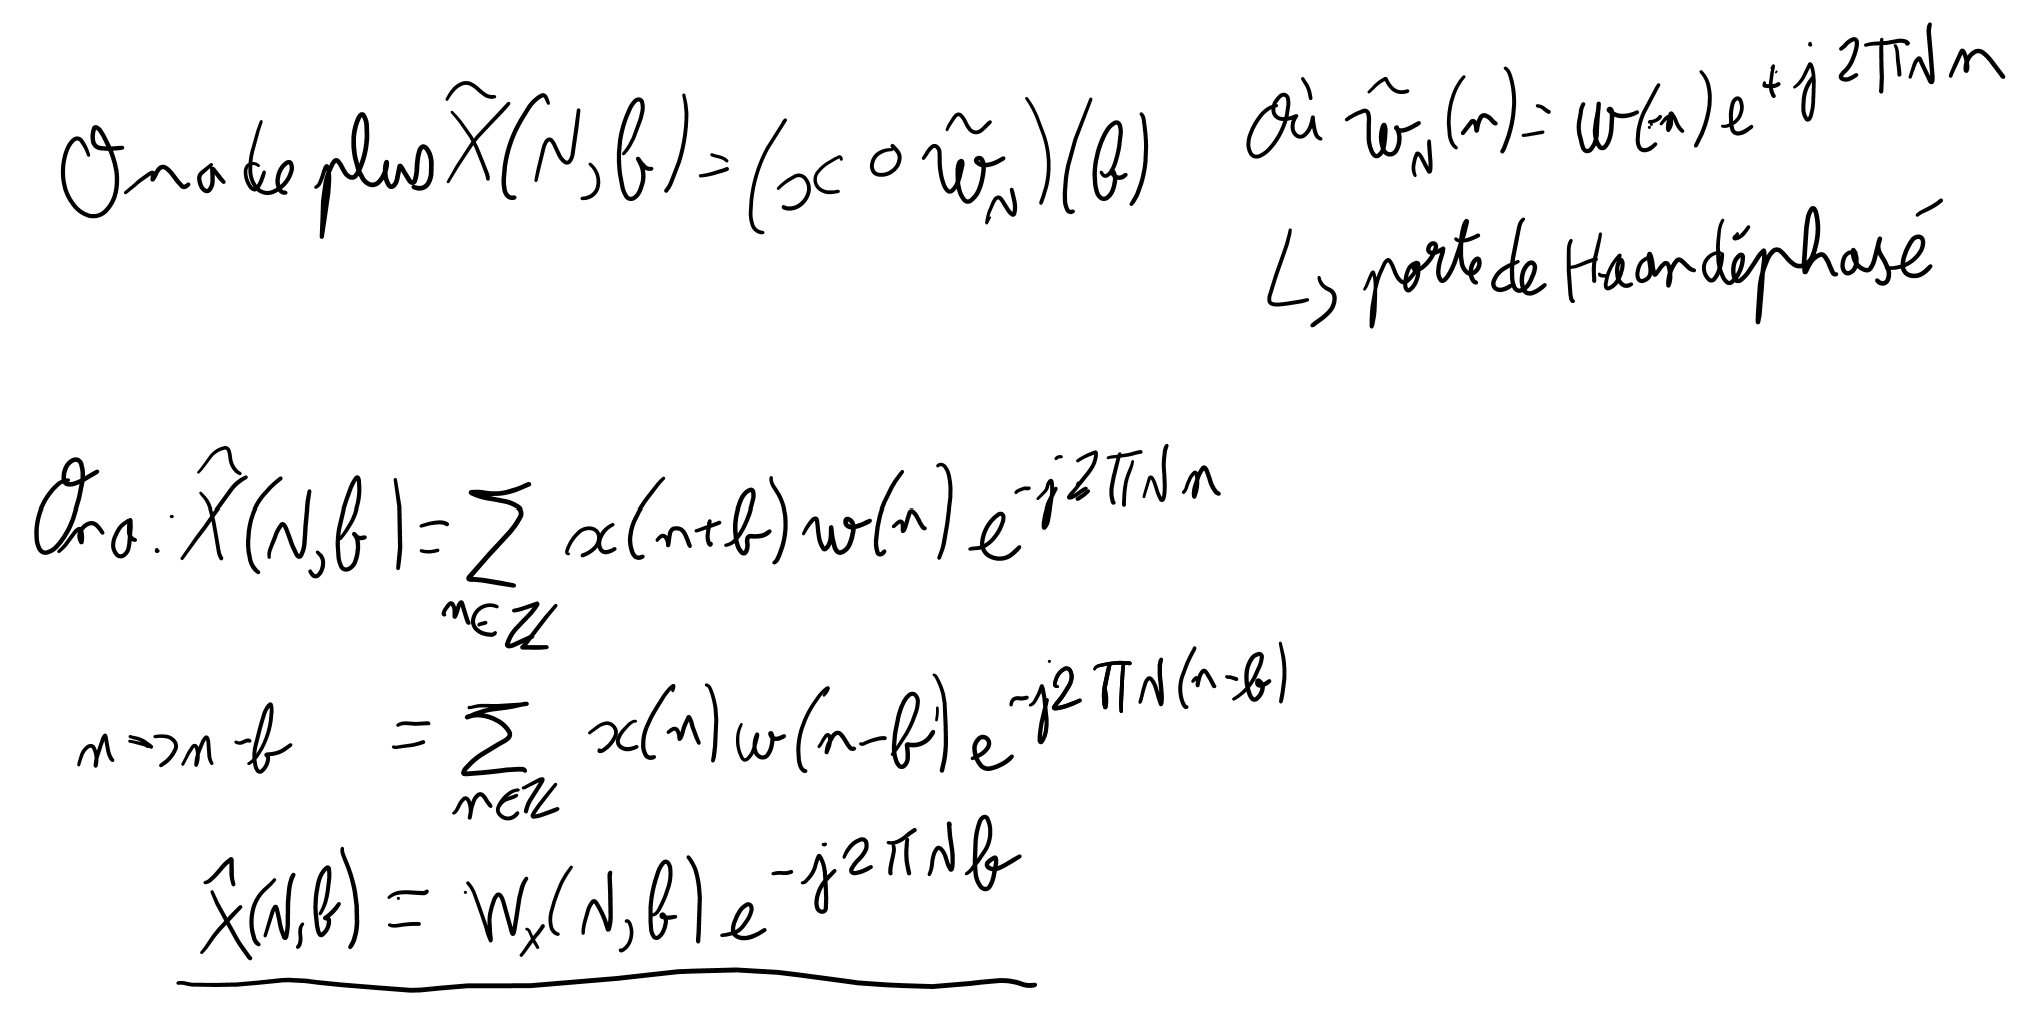

Ici, c'est la porte de Haan directement qui est déphasé, et donc la transformation s'assimilera plutôt à un passe bande dépendant de lambda.

Sur la template, c'est la convention passe-bas qui est utilisé (la première)

Q4

The signal is complex


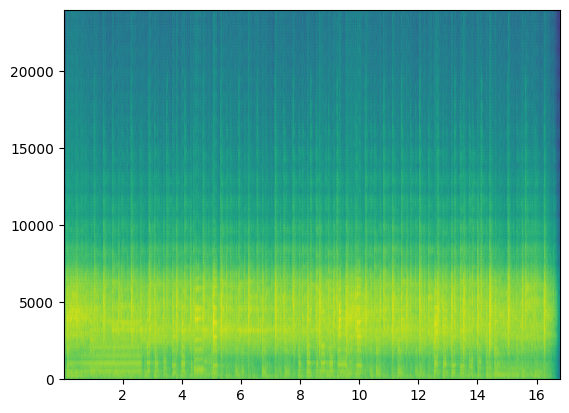

In [175]:
from scipy.signal import spectrogram


for X in Xtilde[3,:]:
    if X.imag>0.00001:
        print("The signal is complex")
        break
X3=Xtilde[3,:]
RE3=np.real(X3)

#spectrogramme
frequence, times, Sxx = spectrogram(RE3, fs=Fs)
plt.pcolormesh(times, frequence, 20 * np.log10(Sxx), shading='gouraud')

On observe bien que pour k=3, le signal est complexe, et que ça correspond bien à un passe bande autour de la fréquence k*Fs/M = 4500 ici pour k=3.

## Overlap-add reconstruction

Q5

Preuve:

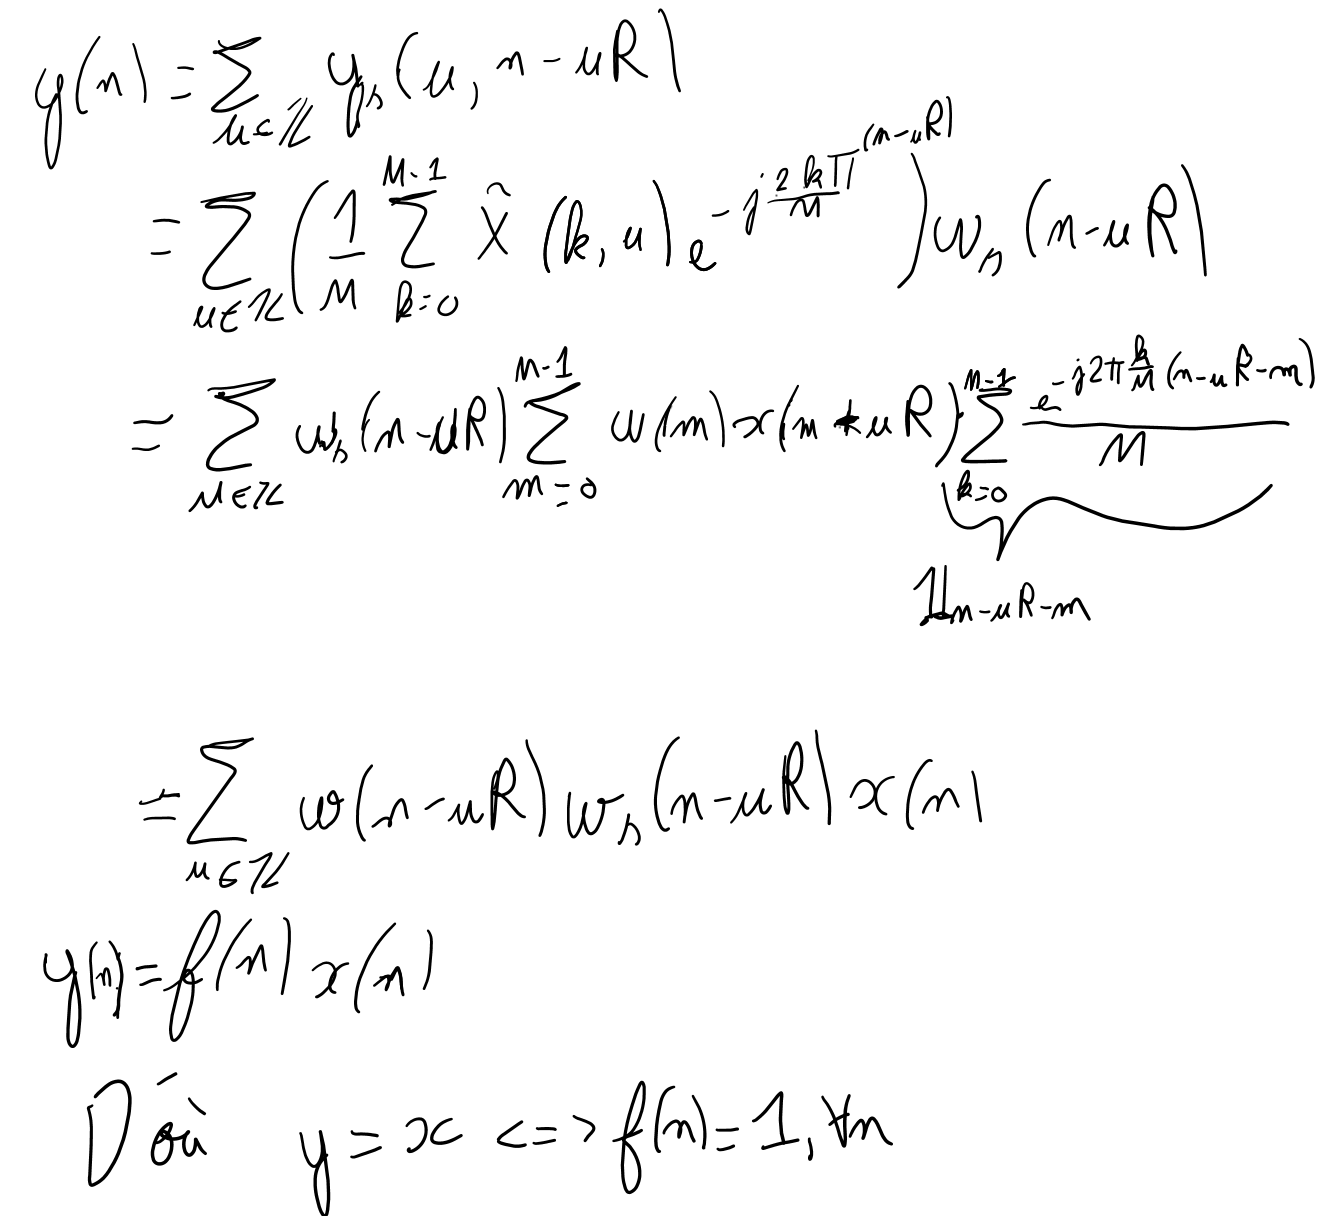

In [176]:
def ola(w = None,hop = None,Nb = 10): 
# function output = ola(w,hop,Nb)
# realise l'addition-recouvrement de la fenetre w,
# avec un décalage hop et un nombre Nb de fenetres.
# par defaut Nb = 10;
    
    w = w[:, np.newaxis]
    N = len(w)
    output = np.zeros(((Nb - 1) * hop + N,1)) # réserve l'espace memoire
    
    for k in np.arange(0,Nb).reshape(-1):
        deb = k* hop
        fin = deb + N
        output[np.arange(deb,fin)] = output[np.arange(deb,fin)] + w # OLA
    
    return output

[0.99813091]


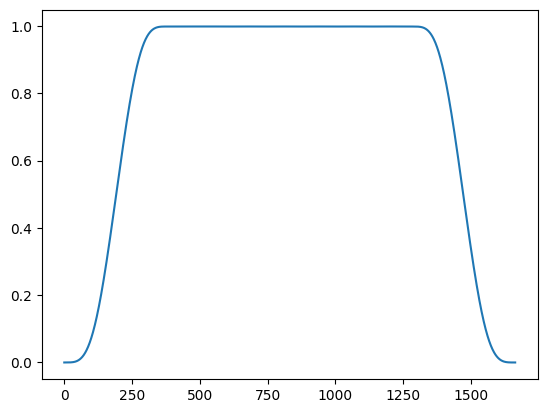

In [177]:
w2=np.hanning(512)

h=w2*w2

fn=ola(h/1.5,int(len(h)/4)) #75% overlap et normalisé (on observe que f(n)=1,5 pour 2 fenêtres de hamming normalisées donc on divise par 1,5
print(max(fn))              #la deuxième fenêtre de Haan, mais on pourrait aussi diviser par sqrt(1,5) chaque fenêtre si on veut avoir 2x la même fonction
plt.plot(fn)



On a alors bien f(n) environ égal à 1

Q6 :


In [178]:
wavefile = load_sound(sound)
print(wavefile.getparams())

_wave_params(nchannels=1, sampwidth=2, framerate=48000, nframes=805733, comptype='NONE', compname='not compressed')


In [179]:
Fs = int(wavefile.getframerate())
num_samples = int(wavefile.getnframes())
data = wavefile.readframes(num_samples)
data = struct.unpack('{n}h'.format(n=num_samples), data)
x = np.array(data)

In [180]:
N = x.shape[0] # % longueur du signal
Nw = 128
w = np.hanning(Nw) # définition de la fenetre d'analyse
ws = np.hanning(Nw); # définition de la fenêtre de synthèse
R = int(0.25 * Nw)  # 75% de recouvrement (overlap), donc hop_size = 25% de la fenêtre
M = 256  #ordre la tfd
L = M/2+1
affich = 1 ; # pour affichage du spectrogramme, 0 pour
             # pour faire analyse/modif/synthèse sans affichage
             # note: cf. spectrogram sous Matlab
Nt = np.rint((N - Nw) / R) # calcul du nombre de tfd à calculer
Nt = Nt.astype(int)
y = np.zeros((N,1)) # signal de synthèse

if affich:
    Xtilde = np.zeros((M,Nt),dtype=complex)

In [181]:
for u in np.arange(0,Nt).reshape(-1): # boucle sur les trames
    deb = u * R + 1 # début de trame
    fin = deb + Nw # fin de trame
    tx = np.multiply(x[np.arange(deb.astype(int),fin.astype(int))],w) # calcul de la trame 
    X = np.fft.fft(tx,M) # tfd à l'instant b
    if affich:
        Xtilde[:,u] = X



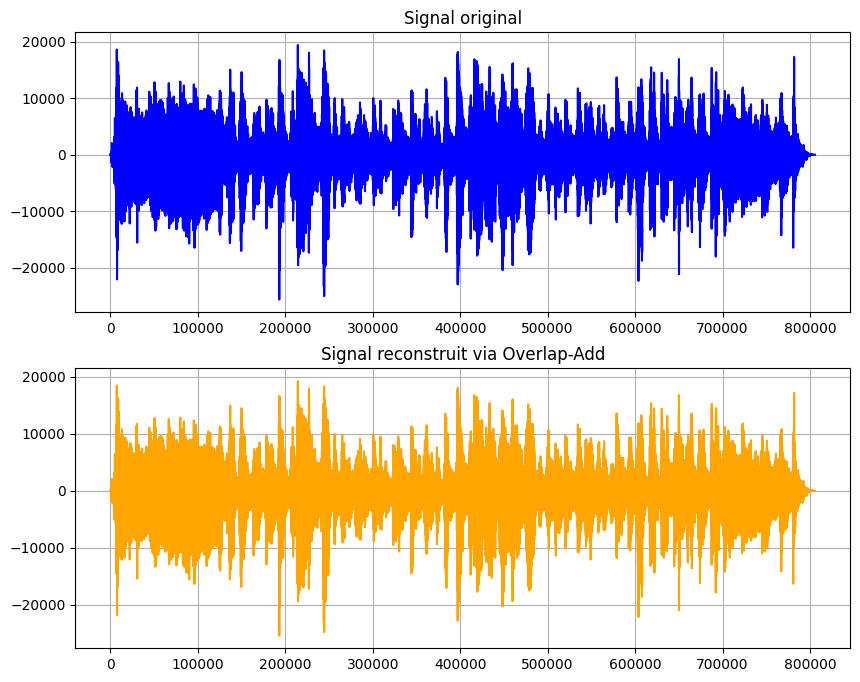

In [187]:


# Variable pour stocker le signal reconstruit via OLA
y_reconstruit = np.zeros(len(x))

# Boucle sur les trames pour la STFT et la resynthèse via Overlap-Add
for u in np.arange(0, Nt):
    deb = u * R  # Début de la trame
    fin = deb + Nw  # Fin de la trame

    X=Xtilde[:,u]

    # Calcul de la resynthèse en utilisant la transformée inverse (iDFT)
    y_s = np.real(np.fft.ifft(X)[:Nw]) * ws

    # Overlap-Add : additionner le signal resynthétisé à l'emplacement correct
    
    y_reconstruit[deb:fin] += y_s/1.5 #on divise bien par 1.5 pour normalisé (cf Q4)

# Affichage
plt.figure(figsize=(10, 8))

# Signal original
plt.subplot(2, 1, 1)
plt.plot(x, label='Signal original', color='blue')
plt.title('Signal original')
plt.grid(True)

#  Signal reconstruit
plt.subplot(2, 1, 2)
plt.plot(y_reconstruit, label='Signal reconstruit via Overlap-Add', color='orange')
plt.title('Signal reconstruit via Overlap-Add')
plt.grid(True)


In [183]:
#Ecoute:
write('caravan_reconstruit.wav', Fs, np.array(y_reconstruit, dtype=np.int16))
sound2 = os.path.join(data_path, 'caravan_reconstruit.wav') 
play = False
if play :
    play_sound(sound2) 

On a bien reconstruit le signal à 100% (en écoutant le nouveau signal et en comparant les graphes des 2 signaux)

Q7 :

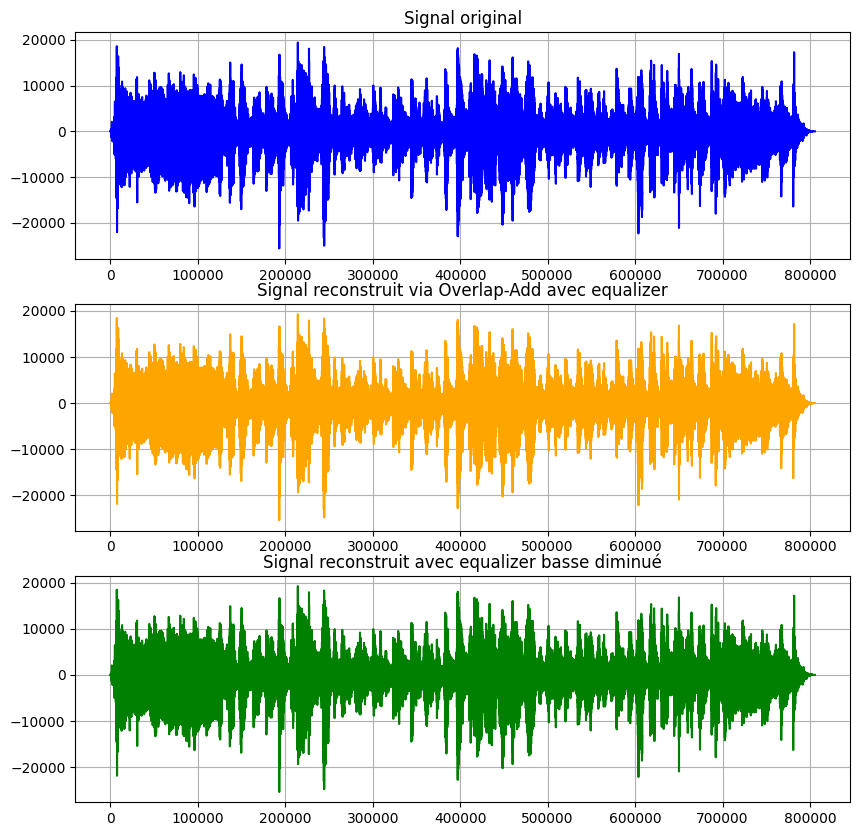

In [197]:
def equalizer (w,X):
    Ytilde = np.zeros((M,Nt),dtype=complex)
    for k in range(len(w)):
        Ytilde[k,:]=X[k,:]*w[k]
    return Ytilde

w=[1 for _ in range(len(Xtilde[:,0]))]

sub=int(M/4)

w1=[0.25 for _ in range(sub)]
for _ in range(M-sub):
    w1.append(1)

def reconstruction_equalizer(w,Xtilde):
    y_reconstruit2 = np.zeros(len(x))
    Ytilde=equalizer(w,Xtilde)
    for u in np.arange(0, Nt):
        deb = u * R  # Début de la trame
        fin = deb + Nw  # Fin de la trame

        Y=Xtilde[:,u]

        # Calcul de la resynthèse en utilisant la transformée inverse (iDFT)
        y_s = np.real(np.fft.ifft(Y)[:Nw]) * ws

        # Overlap-Add : additionner le signal resynthétisé à l'emplacement correct
        
        y_reconstruit2[deb:fin] += y_s/1.5 #on divise bien par 1.5 pour normalisé (cf Q4)"""

    return y_reconstruit2

y_reconstruit2=reconstruction_equalizer(w,Xtilde)
y_basslowered=reconstruction_equalizer(w1,Xtilde)
# Affichage
plt.figure(figsize=(10, 10))

# Signal original
plt.subplot(3, 1, 1)
plt.plot(x, label='Signal original', color='blue')
plt.title('Signal original')
plt.grid(True)

#  Signal reconstruit à 100%
plt.subplot(3, 1, 2)
plt.plot(y_reconstruit2, label='Signal reconstruit via Overlap-Add avec equalizer', color='orange')
plt.title('Signal reconstruit via Overlap-Add avec equalizer')
plt.grid(True)

#  Signal reconstruit avec basses diminués
plt.subplot(3, 1, 3)
plt.plot(y_basslowered, label='Signal reconstruit avec equalizer basse diminué', color='green')
plt.title('Signal reconstruit avec equalizer basse diminué')
plt.grid(True)

In [198]:
#Ecoute:
write('caravan_reconstruit_equalizer.wav', Fs, np.array(y_reconstruit2, dtype=np.int16))
sound2 = os.path.join(data_path, 'caravan_reconstruit_equalizer.wav') 
play = True
if play :
    play_sound(sound2) 

write('caravan_reconstruit_equalizer_basslowered.wav', Fs, np.array(y_reconstruit2, dtype=np.int16))
sound3 = os.path.join(data_path, 'caravan_reconstruit_equalizer_basslowered.wav') 
play = False
if play :
    play_sound(sound3) 

KeyboardInterrupt: 

On a bien y=x pour w=1. En faisant varier w, on peut diminuer certaines fréquences (les basses par exemple en mettant des 0.5 au début de w comme dans l'exemple ci-dessus).